In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import imageio                   #convert numpy array to GIF. Very helpful when dealing with the Videos
from typing import List
import numpy as np

In [2]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)         
except:
    pass

## Building Data Loading Functions
1. Load up our Videos
2. To Preprocess all our Annotations. Annotations are sentences which a person in the Video is talked about.

In [3]:
import gdown

In [8]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=f4438b59-fc34-471c-aa20-9c110bf4cb46
To: E:\PIYUSH_LAVANIYA_CMD\DEEP_LEARNING_Projects\Lip_reading_using_LipNET\data.zip
100%|███████████████████████████████████████████████████████████████████████████████| 423M/423M [01:07<00:00, 6.28MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [3]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [4]:
#Vocab is the every single character which we might encounter within our Annotations

In [5]:
Vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [6]:
Vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [7]:
# Mapping characters to integers
char_to_num = tf.keras.layers.StringLookup(vocabulary=Vocab, oov_token="")

In [8]:
# Mapping integers back to original characters
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

In [9]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [10]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
        
    tokens = [] 
    
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
            
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

## Load the alignments and Videos together

In [49]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    
    file_name = path.split('\\')[-1].split('.')[0]
    
    video_path = os.path.join('User_Data',f'{file_name}.mp4')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [75]:
import cv2    ##Use this function to train your Model for getting the lips movements in the frame.
import numpy as np

def load_video_data(file_path: str) -> np.ndarray:
    cap = cv2.VideoCapture(file_path)
    frames = []
    frame_count = 0

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert frame to grayscale
        
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        
        for (x, y, w, h) in faces:
            lips_roi = frame[y + int(h / 2):y + h, x:x + w]
            lips_roi = cv2.resize(lips_roi, (46, 140))
            lips_roi = cv2.cvtColor(lips_roi, cv2.COLOR_BGR2GRAY)  # Convert lips ROI to grayscale
            frames.append(lips_roi)
            frame_count += 1
            if frame_count >= 75:
                break
        
        if frame_count >= 75:
            break
    
    cap.release()

    while len(frames) < 75:
        frames.append(frames[-1])
    
    video = np.array(frames[:75])
    video = video / 255.0

    video = np.transpose(video, (0, 1, 2))  # Swap the height and width dimensions
    
    video = np.expand_dims(video, axis=-1)  # Add a channel dimension to create single-channel (grayscale) frames
    
    return video.astype(np.float32)


In [71]:
test_path = 'User_Data\\bbaf2n.mpg'

In [72]:
frames = load_video_data(test_path)

In [73]:
frames.shape

(75, 140, 46, 1)

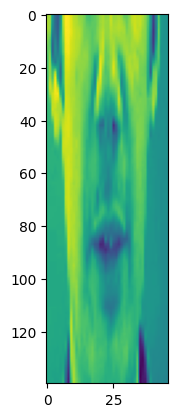

In [74]:
plt.imshow(frames[38])

In [ ]:
alignments

In [19]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [20]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [21]:
def mappable(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## Creating the Tensorflow Data Pipeline

This is to be padded the alignments since they have different lengths. so to get them in a same length we pad them.
'2' is the batch size, '75' is the number of frames, '40' is the size of tokens or numbers of tokens.
If less than 40, it's gonna be padded up with zeros.

In [22]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [22]:
data.as_numpy_iterator().next()

(array([[[[[1.4885758 ],
           [1.4885758 ],
           [1.597496  ],
           ...,
           [0.32676056],
           [0.32676056],
           [0.32676056]],
 
          [[1.5248826 ],
           [1.3796557 ],
           [1.5611893 ],
           ...,
           [0.32676056],
           [0.32676056],
           [0.32676056]],
 
          [[1.4885758 ],
           [1.4885758 ],
           [1.4885758 ],
           ...,
           [0.32676056],
           [0.32676056],
           [0.32676056]],
 
          ...,
 
          [[1.0892018 ],
           [1.0528951 ],
           [1.0528951 ],
           ...,
           [0.14522691],
           [0.14522691],
           [0.10892019]],
 
          [[1.0528951 ],
           [1.0528951 ],
           [1.0528951 ],
           ...,
           [0.03630673],
           [0.03630673],
           [0.03630673]],
 
          [[1.0528951 ],
           [1.0528951 ],
           [1.0528951 ],
           ...,
           [0.03630673],
           [0.03630673

In [23]:
len(data)

500

In [24]:
train = data.take(450)
test = data.skip(450)

In [25]:
len(train)

450

In [26]:
len(test)

50

In [27]:
frames, alignments = data.as_numpy_iterator().next()

In [28]:
len(frames)

2

In [29]:
frames

array([[[[[10.348085  ],
          [10.348085  ],
          [10.348085  ],
          ...,
          [10.348085  ],
          [10.348085  ],
          [10.348085  ]],

         [[10.348085  ],
          [10.348085  ],
          [10.348085  ],
          ...,
          [10.348085  ],
          [10.348085  ],
          [10.348085  ]],

         [[10.348085  ],
          [10.348085  ],
          [10.348085  ],
          ...,
          [10.348085  ],
          [10.348085  ],
          [10.348085  ]],

         ...,

         [[10.348085  ],
          [10.348085  ],
          [10.348085  ],
          ...,
          [10.348085  ],
          [10.348085  ],
          [10.348085  ]],

         [[10.348085  ],
          [10.348085  ],
          [10.348085  ],
          ...,
          [10.348085  ],
          [10.348085  ],
          [10.348085  ]],

         [[10.348085  ],
          [10.348085  ],
          [10.348085  ],
          ...,
          [10.348085  ],
          [10.348085  ],
          

In [30]:
sample = data.as_numpy_iterator()

In [32]:
val = sample.next(); val[0]

array([[[[[ 1.5807217 ],
          [ 1.618358  ],
          [ 1.4301769 ],
          ...,
          [ 0.41399854],
          [ 0.41399854],
          [ 0.37636232]],

         [[ 1.618358  ],
          [ 1.6936305 ],
          [ 1.467813  ],
          ...,
          [ 0.41399854],
          [ 0.41399854],
          [ 0.37636232]],

         [[ 1.467813  ],
          [ 1.467813  ],
          [ 1.467813  ],
          ...,
          [ 0.3387261 ],
          [ 0.3387261 ],
          [ 0.3387261 ]],

         ...,

         [[ 1.0914507 ],
          [ 1.0538145 ],
          [ 1.0538145 ],
          ...,
          [ 0.15054493],
          [ 0.15054493],
          [ 0.15054493]],

         [[ 1.0538145 ],
          [ 1.0538145 ],
          [ 1.0538145 ],
          ...,
          [ 0.15054493],
          [ 0.15054493],
          [ 0.1129087 ]],

         [[ 1.0538145 ],
          [ 1.0538145 ],
          [ 1.0538145 ],
          ...,
          [ 0.1129087 ],
          [ 0.1129087 ],
          

In [34]:
val[0]  #These are the frames.

array([[[[[1.2259306 ],
          [1.2259306 ],
          [1.2259306 ],
          ...,
          [0.26817232],
          [0.26817232],
          [0.26817232]],

         [[1.0726893 ],
          [1.1109996 ],
          [1.1876203 ],
          ...,
          [0.26817232],
          [0.26817232],
          [0.26817232]],

         [[0.91944796],
          [1.0726893 ],
          [0.91944796],
          ...,
          [0.30648264],
          [0.26817232],
          [0.26817232]],

         ...,

         [[1.1876203 ],
          [1.1876203 ],
          [1.1876203 ],
          ...,
          [0.11493099],
          [0.07662066],
          [0.07662066]],

         [[1.14931   ],
          [1.14931   ],
          [1.14931   ],
          ...,
          [0.11493099],
          [0.07662066],
          [0.07662066]],

         [[1.14931   ],
          [1.14931   ],
          [1.14931   ],
          ...,
          [0.11493099],
          [0.07662066],
          [0.07662066]]],


        [[[1.1493

In [35]:
val[0][0]  #this second '0' defines what number of video. Since now we have a set of two videos so it can also be set to '1'.

array([[[[1.2259306 ],
         [1.2259306 ],
         [1.2259306 ],
         ...,
         [0.26817232],
         [0.26817232],
         [0.26817232]],

        [[1.0726893 ],
         [1.1109996 ],
         [1.1876203 ],
         ...,
         [0.26817232],
         [0.26817232],
         [0.26817232]],

        [[0.91944796],
         [1.0726893 ],
         [0.91944796],
         ...,
         [0.30648264],
         [0.26817232],
         [0.26817232]],

        ...,

        [[1.1876203 ],
         [1.1876203 ],
         [1.1876203 ],
         ...,
         [0.11493099],
         [0.07662066],
         [0.07662066]],

        [[1.14931   ],
         [1.14931   ],
         [1.14931   ],
         ...,
         [0.11493099],
         [0.07662066],
         [0.07662066]],

        [[1.14931   ],
         [1.14931   ],
         [1.14931   ],
         ...,
         [0.11493099],
         [0.07662066],
         [0.07662066]]],


       [[[1.14931   ],
         [1.4557927 ],
         [1.30

In [36]:
val[0][1]

array([[[[1.3444525 ],
         [1.4859738 ],
         [1.5921148 ],
         ...,
         [0.35380328],
         [0.35380328],
         [0.35380328]],

        [[1.3090721 ],
         [1.4505935 ],
         [1.5567344 ],
         ...,
         [0.35380328],
         [0.35380328],
         [0.35380328]],

        [[1.5213541 ],
         [1.5213541 ],
         [1.4859738 ],
         ...,
         [0.35380328],
         [0.28304264],
         [0.28304264]],

        ...,

        [[1.0260296 ],
         [1.0260296 ],
         [1.0260296 ],
         ...,
         [0.10614099],
         [0.10614099],
         [0.10614099]],

        [[0.9906492 ],
         [0.9906492 ],
         [0.9906492 ],
         ...,
         [0.10614099],
         [0.10614099],
         [0.07076066]],

        [[0.9906492 ],
         [0.9906492 ],
         [0.9906492 ],
         ...,
         [0.07076066],
         [0.07076066],
         [0.07076066]]],


       [[[1.4505935 ],
         [1.4505935 ],
         [1.52

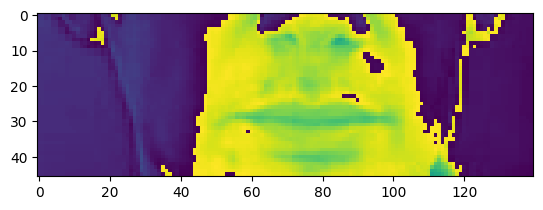

In [33]:
plt.imshow(val[0][0][73])

In [34]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in f zero please'>

## Building a Deep Neural Network

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Bidirectional, Dropout, Dense, Flatten, MaxPooling3D, MaxPool3D, LSTM, Reshape, Input, Activation, SpatialDropout3D, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [37]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [38]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))    ##TimeDistributed layer applies time related data to separate layers (sharing same weights). #preserving the temporal component, i.e. '75'

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation = 'softmax'))


In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [47]:
yhat = model.predict(val[0])

1/1 [==============================] - 21s 21s/step


In [50]:
tf.strings.reduce_join(num_to_char([x for x in tf.argmax(yhat[0], axis = 1)])) 

<tf.Tensor: shape=(), dtype=string, numpy=b"!!!!!!!!'xxxxxxxxx'''''''''''''''''''''''''''''''''''''''''''''''''''''''''">

In [51]:
# This is what it predicts before training.

In [52]:
yhat[0].shape

(75, 41)

In [53]:
#We are getting 75 outputs, each of these represented as an array of 41 values, which is just a one-hot encoded representation of our vocabulary.

In [58]:
len(char_to_num.get_vocabulary())   #remember we did '+1' in the Dense layer. so '41' values.

40

## Setting up CTC loss and training options

In [40]:
def lr_scheduler(epoch, lr):    #handling our learning rate
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-1)

In [41]:
def CTCLoss(y_true, y_pred):                       #got it from the documentation. It is specially designed for speech recognition tasks.
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [42]:
class Produce_Example(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs = None) -> None:
        data = self.dataset.next()
        predictions = model.predict(data[0])
        decode = tensorflow.keras.backend.ctc_decode(predictions, [75, 75], greedy = False)[0][0].numpy()  #ctc_decode is used to decode the outputs of the ctc trained models.
        for x in range(len(predictions)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

            #printing the prediction every epoch


In [43]:
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001), loss = CTCLoss)

In [44]:
checkpoint_callback = ModelCheckpoint(os.path.join('model', 'checkpoint'), monitor = 'loss', save_weights_only = True)  #when we load our weights again we will need to initialize or create our model again.

In [45]:
schedule_callback = LearningRateScheduler(lr_scheduler)  #setting our learning rate scheduler

In [46]:
example_callback = Produce_Example(test)

Training our Deep Learning Model

In [ ]:
model.fit(train, validation_data=test, epochs = 100, callbacks = [checkpoint_callback, schedule_callback, example_callback])

## Predicting Using our Model

In [75]:
url = "https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y"
output = "checkpoint.zip"
gdown.download(url, output, quiet = False)
gdown.extractall("checkpoint.zip", "model")

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=c0a3a481-540c-470a-87ee-84daebcc3042
To: E:\PIYUSH_LAVANIYA_CMD\DEEP_LEARNING_Projects\Lip_reading_using_LipNET\checkpoint.zip
100%|█████████████████████████████████████████████████████████████████████████████| 94.5M/94.5M [00:14<00:00, 6.55MB/s]


['model\\checkpoint.index',
 'model\\__MACOSX/._checkpoint.index',
 'model\\checkpoint.data-00000-of-00001',
 'model\\__MACOSX/._checkpoint.data-00000-of-00001',
 'model\\checkpoint',
 'model\\__MACOSX/._checkpoint']

In [76]:
#loading the checkpoints

In [47]:
model.load_weights('model/checkpoint')

In [48]:
test_data = test.as_numpy_iterator()

In [49]:
sample_data = test_data.next()

In [50]:
yhat = model.predict(sample_data[0])

1/1 [==============================] - 17s 17s/step


In [52]:
print('REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample_data[1]]

REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue at o eight now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green at t nine soon'>]

In [53]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length = [75, 75], greedy = True)[0][0].numpy()

In [56]:
print('PREDICTION')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

PREDICTION


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue at o eight now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green at t nine soon'>]

In [57]:
#testing on a Video

In [59]:
sample_video = load_data(tf.convert_to_tensor('.\\data\\s1\\bbaf4p.mpg'))  #we have to convert it to tensor because 'str' object has no attribute 'numpy'

In [62]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample_video[1]]]  #we wrapped the sample_video[1] because of this error : Cannot iterate over a scalar tensor

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f four please'>]

In [74]:
yhat = model.predict(tf.expand_dims(sample_video[0], axis = 0)) #we need to use expand dims

1/1 [==============================] - 7s 7s/step


In [71]:
sample_video[0].shape   #the error is : input must be 5-dimensional

TensorShape([75, 46, 140, 1])

In [73]:
tf.expand_dims(sample_video[0], axis = 0).shape   #so we do this

TensorShape([1, 75, 46, 140, 1])

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length = [75, 75], greedy = True)[0][0].numpy()

In [84]:
#We got an error, So we do this
decoded = tf.keras.backend.ctc_decode(yhat, input_length = [75], greedy = True)[0][0].numpy()

In [85]:
print('ORIGINAL')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample_video[1]]]

ORIGINAL


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f four please'>]

In [86]:
print('PREDICTION')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

PREDICTION


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f four please'>]